# Módulo 4 - Projeto 2: *SVR, Grid Search & Random Search*

# Nome aluno 1: Gustavo da Silva Arantes           
# Nome aluno 2: Matheus Pelichek Bueno
# Projeto realizado na plataforma Google Colab

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitora: Alana Santana -- a229999@dac.unicamp.br

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina: 
[moodle.lab.ic.unicamp.br/391](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=391)

Instituto de Computação - Unicamp 2020

In [0]:
from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import seaborn as sns

from IPython.display import display

from google.colab import drive

## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas à um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/doctor-fees-train.csv')
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pre-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [0]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [0]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [6]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [0]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)
    
    return g

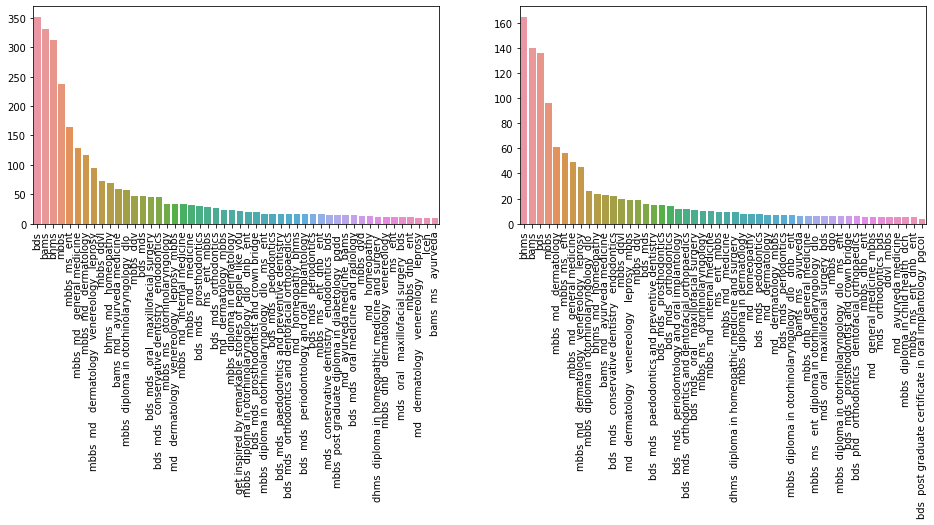

In [8]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

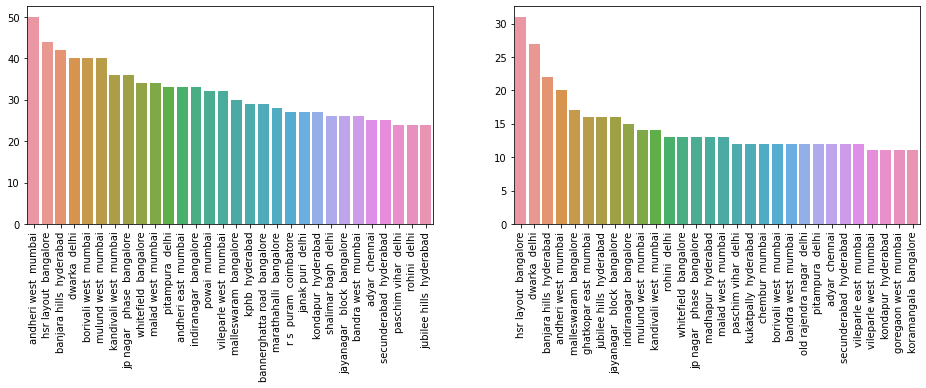

In [9]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

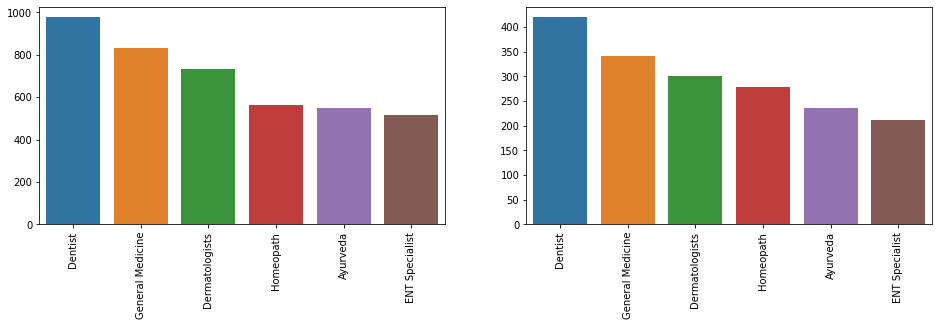

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [0]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Imputamos (substituímos as células desconhecidas pelo valor mediano) e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [0]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [0]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()
y_train = train['Fees'].astype(float).ravel()
y_test = test['Fees'].astype(float).ravel()

**Atividade (5 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)`.

In [0]:
np.random.seed(1082141)
sns.set()

#SVR Linear

Para o SVR linear, variamos o C e o Epsilon utilizando o gridsearch:

In [50]:
# define os valores dos parametros
C_range = [0.1, 1, 5, 10, 25, 50]
Epsilon_range = [0.001, 0.01, 10, 50, 100]
# cria o grid do parametro
param_grid = dict(C=C_range, epsilon=Epsilon_range)
# instantiate the grid
grid = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid=param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# do the Fit
grid.fit(train_e, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10, 25, 50],
                         'epsilon': [0.001, 0.01, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [51]:
grid.cv_results_['mean_test_score']

array([-35146.72523817, -35146.87039492, -35356.66794529, -36179.01806143,
       -35122.75821521, -33236.59412946, -33236.69189453, -33270.83621204,
       -32827.34449156, -32442.93873618, -31929.86604559, -31930.02985672,
       -31851.92933826, -31765.02749895, -31371.83340444, -31548.52257278,
       -31548.4905338 , -31434.54443144, -31292.54659972, -30929.21412691,
       -31755.85798502, -31755.32758799, -31547.89626589, -31339.95266258,
       -30664.98084842, -32349.98201034, -32349.55092175, -32064.74257631,
       -31483.56016724, -30692.65035144])

In [52]:
grid.cv_results_['params']

[{'C': 0.1, 'epsilon': 0.001},
 {'C': 0.1, 'epsilon': 0.01},
 {'C': 0.1, 'epsilon': 10},
 {'C': 0.1, 'epsilon': 50},
 {'C': 0.1, 'epsilon': 100},
 {'C': 1, 'epsilon': 0.001},
 {'C': 1, 'epsilon': 0.01},
 {'C': 1, 'epsilon': 10},
 {'C': 1, 'epsilon': 50},
 {'C': 1, 'epsilon': 100},
 {'C': 5, 'epsilon': 0.001},
 {'C': 5, 'epsilon': 0.01},
 {'C': 5, 'epsilon': 10},
 {'C': 5, 'epsilon': 50},
 {'C': 5, 'epsilon': 100},
 {'C': 10, 'epsilon': 0.001},
 {'C': 10, 'epsilon': 0.01},
 {'C': 10, 'epsilon': 10},
 {'C': 10, 'epsilon': 50},
 {'C': 10, 'epsilon': 100},
 {'C': 25, 'epsilon': 0.001},
 {'C': 25, 'epsilon': 0.01},
 {'C': 25, 'epsilon': 10},
 {'C': 25, 'epsilon': 50},
 {'C': 25, 'epsilon': 100},
 {'C': 50, 'epsilon': 0.001},
 {'C': 50, 'epsilon': 0.01},
 {'C': 50, 'epsilon': 10},
 {'C': 50, 'epsilon': 50},
 {'C': 50, 'epsilon': 100}]

In [53]:
# O melhor modelo é
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-30664.980848419385
{'C': 25, 'epsilon': 100}
SVR(C=25, cache_size=200, coef0=0.0, degree=3, epsilon=100, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Aplicando o melhor modelo no treino obtem-se:

In [54]:
regressor = SVR(kernel='linear', C = 25, epsilon = 100).fit(train_e, y_train)

prediction = regressor.predict(train_e)
print("MAE = ", mean_absolute_error(y_train, prediction))
print("MSE = ", mean_squared_error(y_train, prediction))
print("R2 = ", r2_score(y_train, prediction))

MAE =  131.38509458816233
MSE =  28686.00259151269
R2 =  0.2121115196887513


Aplicando o melhor modelo no teste obtem-se:

In [55]:
prediction = regressor.predict(test_e)
print("MAE = ", mean_absolute_error(y_test, prediction))
print("MSE = ", mean_squared_error(y_test, prediction))
print("R2 = ", r2_score(y_test, prediction))

MAE =  133.97509861533266
MSE =  30098.086754515098
R2 =  0.17644003592314983


O parâmetro C realizou a regularização do modelo até o valor de 25, posterior a esse valor o modelo começou a ficar muito especializado. A variação de Epsilon se mostrou benéfica para agregar pontos que não estavam tão próximos da curva desenhada. Como esperado, a curva linear não se adaptou bem aos dados resultando em um R2 de 0.176 no teste.

#SVR Polinomial

Para o SVR Polinomial, variamos o C, o Grau e o Epsilon utilizando o gridsearch:

In [56]:
# define os valores dos parametros
C_range = [0.1, 1, 10, 25, 50]
Epsilon_range = [10, 50, 100]
Degree_range = [x + 2 for x in list(range(4))]
# cria o grid do parametro
param_grid = dict(C=C_range, epsilon=Epsilon_range, degree=Degree_range)
# instantiate the grid
grid = GridSearchCV(
        estimator=SVR(kernel='poly'),
        param_grid=param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# do the Fit
grid.fit(train_e, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 25, 50], 'degree': [2, 3, 4, 5],
                         'epsilon': [10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [57]:
grid.cv_results_['mean_test_score']

array([  -36348.42777327,   -39037.54877862,   -36152.56637255,
         -36737.98762177,   -40348.25926568,   -36531.02178217,
         -36594.00138636,   -40121.87597726,   -37338.0028471 ,
         -47954.39180505,   -44155.32015747,   -48774.89805574,
         -35276.99765889,   -36212.11686412,   -34954.37332519,
         -35248.06927609,   -37330.80026378,   -35238.8039113 ,
         -39136.13758961,   -39795.50882173,   -39275.44789292,
         -41887.05024485,   -47095.17812987,   -63609.53223695,
         -32697.09666678,   -32392.21972457,   -31905.93007684,
         -33403.08291397,   -33290.24249802,   -32909.00190358,
         -50975.12298683,   -52223.62804242,   -50156.67000667,
       -1301622.76824162,  -695304.1178102 ,  -483849.40319198,
         -31831.78188398,   -31735.8526331 ,   -31202.67441465,
         -32958.9397655 ,   -32652.74538061,   -32455.20782465,
        -111717.57754295,   -96985.00457998,   -78430.87528701,
       -1792967.80266104, -1117478.33373

In [58]:
grid.cv_results_['params']

[{'C': 0.1, 'degree': 2, 'epsilon': 10},
 {'C': 0.1, 'degree': 2, 'epsilon': 50},
 {'C': 0.1, 'degree': 2, 'epsilon': 100},
 {'C': 0.1, 'degree': 3, 'epsilon': 10},
 {'C': 0.1, 'degree': 3, 'epsilon': 50},
 {'C': 0.1, 'degree': 3, 'epsilon': 100},
 {'C': 0.1, 'degree': 4, 'epsilon': 10},
 {'C': 0.1, 'degree': 4, 'epsilon': 50},
 {'C': 0.1, 'degree': 4, 'epsilon': 100},
 {'C': 0.1, 'degree': 5, 'epsilon': 10},
 {'C': 0.1, 'degree': 5, 'epsilon': 50},
 {'C': 0.1, 'degree': 5, 'epsilon': 100},
 {'C': 1, 'degree': 2, 'epsilon': 10},
 {'C': 1, 'degree': 2, 'epsilon': 50},
 {'C': 1, 'degree': 2, 'epsilon': 100},
 {'C': 1, 'degree': 3, 'epsilon': 10},
 {'C': 1, 'degree': 3, 'epsilon': 50},
 {'C': 1, 'degree': 3, 'epsilon': 100},
 {'C': 1, 'degree': 4, 'epsilon': 10},
 {'C': 1, 'degree': 4, 'epsilon': 50},
 {'C': 1, 'degree': 4, 'epsilon': 100},
 {'C': 1, 'degree': 5, 'epsilon': 10},
 {'C': 1, 'degree': 5, 'epsilon': 50},
 {'C': 1, 'degree': 5, 'epsilon': 100},
 {'C': 10, 'degree': 2, 'epsilon

In [59]:
# O melhor modelo é
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-30883.087252889505
{'C': 50, 'degree': 2, 'epsilon': 100}
SVR(C=50, cache_size=200, coef0=0.0, degree=2, epsilon=100, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Aplicando o melhor modelo no treino obtem-se:

In [60]:
regressor = SVR(kernel='poly', C = 50, degree = 2, epsilon = 100).fit(train_e, y_train)

prediction = regressor.predict(train_e)
print("MAE = ", mean_absolute_error(y_train, prediction))
print("MSE = ", mean_squared_error(y_train, prediction))
print("R2 = ", r2_score(y_train, prediction))

MAE =  130.07966543867332
MSE =  27226.29486126283
R2 =  0.25220378774234964


Aplicando o melhor modelo no teste obtem-se:

In [61]:
prediction = regressor.predict(test_e)
print("MAE = ", mean_absolute_error(y_test, prediction))
print("MSE = ", mean_squared_error(y_test, prediction))
print("R2 = ", r2_score(y_test, prediction))

MAE =  133.821620160201
MSE =  29010.372731430238
R2 =  0.20620264937708543


O parâmetro C realizou a regularização do modelo até o valor de 50, posterior a esse valor o modelo começou a ficar muito especializado. A variação de Epsilon se mostrou benéfica para agregar pontos que não estavam tão próximos da curva desenhada. O aumento do grau do polinômio não resultou em boas métricas (R2 de 0.206 no teste), concluindo que o modelo polinomial não se adaptou bem aos dados.

#SVR RBF

Para o SVR RBF, variamos o C, o Gamma e o Epsilon utilizando o gridsearch:

In [74]:
# define os valores dos parametros
C_range = [10, 25, 50, 75, 100]
Epsilon_range = [50, 75, 100, 150]
Gamma_range = [0.001, 0.01, 0.1, 1]
# cria o grid do parametro
param_grid = dict(C=C_range, epsilon=Epsilon_range, gamma=Gamma_range)
# instantiate the grid
grid = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
# do the Fit
grid.fit(train_e, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [10, 25, 50, 75, 100],
                         'epsilon': [50, 75, 100, 150],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [75]:
grid.cv_results_['mean_test_score']

array([-38699.40060941, -34908.27517178, -32203.56381537, -33374.41196922,
       -36863.33712272, -34410.01032492, -31917.79835425, -33061.3371318 ,
       -36137.28486953, -34365.21741308, -31717.04292798, -32951.74524721,
       -36089.53233438, -34221.06360276, -32221.71362023, -33136.54606967,
       -37509.07890546, -33395.77070645, -31551.9913129 , -32582.03455055,
       -36156.55866749, -33344.28057314, -31189.78317086, -32422.85451873,
       -35698.57638793, -33048.4491285 , -30997.36312944, -32181.6001194 ,
       -35618.08882697, -33032.51887815, -31626.11728558, -32572.92249229,
       -36173.82194686, -32711.05901894, -31025.64330329, -32128.57949501,
       -35375.43277838, -32659.94999261, -30683.91990386, -31893.43238537,
       -35118.98316124, -32293.93052799, -30551.36959439, -31732.8374818 ,
       -35065.56381995, -32596.54221526, -31183.43194999, -32393.34972203,
       -35399.30491358, -32414.51835136, -30786.88009425, -31932.77239596,
       -34813.99898765, -

In [76]:
grid.cv_results_['params']

[{'C': 10, 'epsilon': 50, 'gamma': 0.001},
 {'C': 10, 'epsilon': 50, 'gamma': 0.01},
 {'C': 10, 'epsilon': 50, 'gamma': 0.1},
 {'C': 10, 'epsilon': 50, 'gamma': 1},
 {'C': 10, 'epsilon': 75, 'gamma': 0.001},
 {'C': 10, 'epsilon': 75, 'gamma': 0.01},
 {'C': 10, 'epsilon': 75, 'gamma': 0.1},
 {'C': 10, 'epsilon': 75, 'gamma': 1},
 {'C': 10, 'epsilon': 100, 'gamma': 0.001},
 {'C': 10, 'epsilon': 100, 'gamma': 0.01},
 {'C': 10, 'epsilon': 100, 'gamma': 0.1},
 {'C': 10, 'epsilon': 100, 'gamma': 1},
 {'C': 10, 'epsilon': 150, 'gamma': 0.001},
 {'C': 10, 'epsilon': 150, 'gamma': 0.01},
 {'C': 10, 'epsilon': 150, 'gamma': 0.1},
 {'C': 10, 'epsilon': 150, 'gamma': 1},
 {'C': 25, 'epsilon': 50, 'gamma': 0.001},
 {'C': 25, 'epsilon': 50, 'gamma': 0.01},
 {'C': 25, 'epsilon': 50, 'gamma': 0.1},
 {'C': 25, 'epsilon': 50, 'gamma': 1},
 {'C': 25, 'epsilon': 75, 'gamma': 0.001},
 {'C': 25, 'epsilon': 75, 'gamma': 0.01},
 {'C': 25, 'epsilon': 75, 'gamma': 0.1},
 {'C': 25, 'epsilon': 75, 'gamma': 1},
 {

In [77]:
# O melhor modelo é
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-30212.7010784443
{'C': 100, 'epsilon': 100, 'gamma': 0.1}
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=100, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Aplicando o melhor modelo no treino obtem-se:

In [78]:
regressor = SVR(kernel='rbf', C = 100, gamma = 0.1, epsilon = 100).fit(train_e, y_train)

prediction = regressor.predict(train_e)
print("MAE = ", mean_absolute_error(y_train, prediction))
print("MSE = ", mean_squared_error(y_train, prediction))
print("R2 = ", r2_score(y_train, prediction))

MAE =  129.4331839081338
MSE =  27235.3495930737
R2 =  0.2519550908783187


Aplicando o melhor modelo no teste obtem-se:

In [79]:
prediction = regressor.predict(test_e)
print("MAE = ", mean_absolute_error(y_test, prediction))
print("MSE = ", mean_squared_error(y_test, prediction))
print("R2 = ", r2_score(y_test, prediction))

MAE =  132.3856716084341
MSE =  28803.609029921576
R2 =  0.21186022847756858


O parâmetro C realizou a regularização do modelo até o valor de 50, posterior a esse valor o modelo começou a ficar muito especializado. A variação de Epsilon se mostrou benéfica para agregar pontos que não estavam tão próximos da curva desenhada. O melhor gamma encontrado resultou em um R2 de 0.212 no teste, resultado esse não tão bom quanto esperado.

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [80]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.4,
                                                    random_state=183212
                                                    )

print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 1078
amostras em teste: 719
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

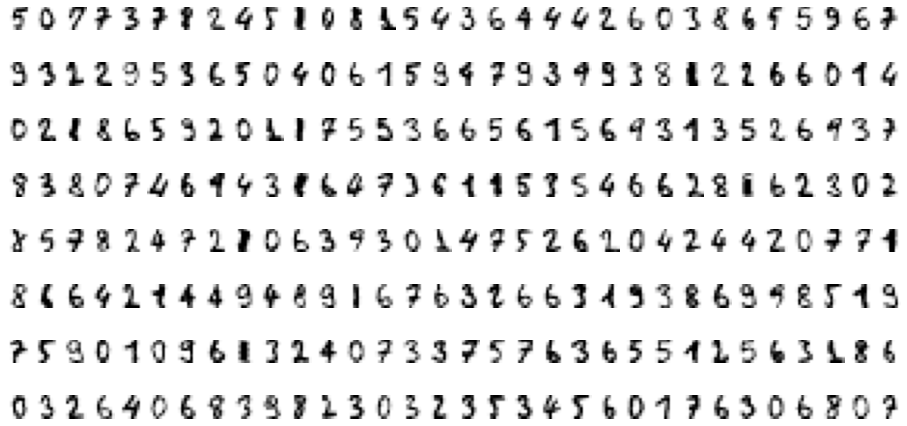

In [82]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

In [0]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

In [0]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

Definindo uma função geradora do Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(title)
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')

Normalizando:

In [0]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Grid search em torno do Kernel Linear:

In [85]:
# define os valores do parametro 
C_range = np.logspace(-2, 10, 8)
# cria o grid do parametro
param_grid = dict(C=C_range)
# define kernel
svm = SVC(kernel = 'linear', decision_function_shape='ovr')
# instantiate the grid
grid = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
# do the Fit
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-02, 5.17947468e-01, 2.68269580e+01, 1.38949549e+03,
       7.19685673e+04, 3.72759372e+06, 1.93069773e+08, 1.00000000e+10])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [86]:
grid.cv_results_['mean_test_score']

array([0.96566286, 0.98052094, 0.98052094, 0.98052094, 0.98052094,
       0.98052094, 0.98052094, 0.98052094])

In [87]:
grid.cv_results_['params']

[{'C': 0.01},
 {'C': 0.517947467923121},
 {'C': 26.826957952797247},
 {'C': 1389.4954943731361},
 {'C': 71968.56730011514},
 {'C': 3727593.720314938},
 {'C': 193069772.88832456},
 {'C': 10000000000.0}]

In [88]:
# O melhor modelo é
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.98052094150225
{'C': 0.517947467923121}
SVC(C=0.517947467923121, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

Vemos que o melhor resultado do Kernel Linear obtido acima é para C = 0,518, com acurácia normalizada de 0.9805 na validação. No teste ele manteve a qualidade do resultado, com acurácia normalizada de 0.9731. Abaixo plotamos o Confusion Matrix para o teste:

Matriz de confusão Teste (em quantidade de elementos)
[[79  0  0  0  0  0  0  0  0  0]
 [ 0 72  0  0  0  0  0  0  0  0]
 [ 0  0 68  0  0  0  0  0  0  0]
 [ 0  0  1 69  0  0  0  0  0  0]
 [ 0  0  0  0 77  0  0  0  0  0]
 [ 0  1  0  0  0 77  0  0  0  0]
 [ 1  1  0  0  0  0 58  0  0  0]
 [ 0  0  0  0  2  1  0 67  0  1]
 [ 0  3  1  2  0  1  0  0 66  0]
 [ 0  1  0  0  0  1  0  0  2 67]]
Classificações corretas = 700
Acurácia normalizada = 0.9730993972263506


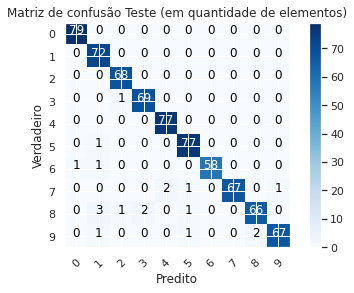

In [92]:
clf = SVC(kernel='linear', C=0.518, decision_function_shape='ovr')
clf.fit(x_train, y_train)

# Calcula matriz de confusão para teste
cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
np.set_printoptions(precision=2)

title = 'Matriz de confusão Teste (em quantidade de elementos)'

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), title=title)

print('Classificações corretas =', accuracy_score(y_test,  clf.predict(x_test), normalize=False))
print('Acurácia normalizada =', recall_score(y_test,  clf.predict(x_test), average='macro'))

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [97]:
C_range = np.logspace(-1, 4, 8)
gamma_range = np.logspace(-5, 2, 8)
param_grid = dict(gamma=gamma_range, C=C_range)
svm = SVC(kernel = 'rbf', decision_function_shape='ovr')
# instantiate the grid
grid = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
# do the Fit
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00e-01, 5.18e-01, 2.68e+00, 1.39e+01, 7.20e+01, 3.73e+02,
       1.93e+03, 1.00e+04]),
                         'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [98]:
grid.cv_results_['mean_test_score']

array([0.11, 0.11, 0.24, 0.91, 0.31, 0.11, 0.11, 0.11, 0.11, 0.11, 0.9 ,
       0.96, 0.89, 0.11, 0.11, 0.11, 0.11, 0.81, 0.96, 0.98, 0.94, 0.13,
       0.11, 0.11, 0.59, 0.95, 0.98, 0.98, 0.94, 0.13, 0.11, 0.11, 0.92,
       0.97, 0.98, 0.98, 0.94, 0.13, 0.11, 0.11, 0.96, 0.98, 0.98, 0.98,
       0.94, 0.13, 0.11, 0.11, 0.98, 0.98, 0.98, 0.98, 0.94, 0.13, 0.11,
       0.11, 0.97, 0.98, 0.98, 0.98, 0.94, 0.13, 0.11, 0.11])

In [99]:
grid.cv_results_['params']

[{'C': 0.1, 'gamma': 1e-05},
 {'C': 0.1, 'gamma': 0.0001},
 {'C': 0.1, 'gamma': 0.001},
 {'C': 0.1, 'gamma': 0.01},
 {'C': 0.1, 'gamma': 0.1},
 {'C': 0.1, 'gamma': 1.0},
 {'C': 0.1, 'gamma': 10.0},
 {'C': 0.1, 'gamma': 100.0},
 {'C': 0.5179474679231212, 'gamma': 1e-05},
 {'C': 0.5179474679231212, 'gamma': 0.0001},
 {'C': 0.5179474679231212, 'gamma': 0.001},
 {'C': 0.5179474679231212, 'gamma': 0.01},
 {'C': 0.5179474679231212, 'gamma': 0.1},
 {'C': 0.5179474679231212, 'gamma': 1.0},
 {'C': 0.5179474679231212, 'gamma': 10.0},
 {'C': 0.5179474679231212, 'gamma': 100.0},
 {'C': 2.682695795279726, 'gamma': 1e-05},
 {'C': 2.682695795279726, 'gamma': 0.0001},
 {'C': 2.682695795279726, 'gamma': 0.001},
 {'C': 2.682695795279726, 'gamma': 0.01},
 {'C': 2.682695795279726, 'gamma': 0.1},
 {'C': 2.682695795279726, 'gamma': 1.0},
 {'C': 2.682695795279726, 'gamma': 10.0},
 {'C': 2.682695795279726, 'gamma': 100.0},
 {'C': 13.894954943731374, 'gamma': 1e-05},
 {'C': 13.894954943731374, 'gamma': 0.0001}

In [100]:
# O melhor modelo é
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9805295950155765
{'C': 2.682695795279726, 'gamma': 0.01}
SVC(C=2.682695795279726, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo. 

In [0]:
C_range = np.logspace(-2, 10, 10)
gamma_range = np.logspace(-9, 3, 10)
param_dist = dict(gamma=gamma_range, C=C_range)
svm = SVC(kernel = 'rbf', decision_function_shape='ovr')

In [106]:
rand = RandomizedSearchCV(svm, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

array([0.94, 0.11, 0.94, 0.11, 0.98, 0.11, 0.11, 0.11, 0.11, 0.98])

In [107]:
# melhor modelo
print(rand.best_score_)
print(rand.best_params_)

0.9823987538940809
{'gamma': 0.004641588833612773, 'C': 100.0}


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

Parâmetros obtidos pelo GridSearch

Vemos que o melhor resultado do Kernel RBF obtido com GridSearch é para C = 2.683 e Gamma = 0.01, com acurácia normalizada de 0.9805 na validação. No teste ele manteve a qualidade do resultado, com acurácia normalizada de 0.9845. Abaixo plotamos o Confusion Matrix para o teste:

Matriz de confusão Teste (em quantidade de elementos)
[[79  0  0  0  0  0  0  0  0  0]
 [ 0 72  0  0  0  0  0  0  0  0]
 [ 0  0 67  0  1  0  0  0  0  0]
 [ 0  0  1 68  1  0  0  0  0  0]
 [ 0  0  0  0 77  0  0  0  0  0]
 [ 0  0  0  0  0 78  0  0  0  0]
 [ 0  0  0  0  0  0 60  0  0  0]
 [ 0  0  0  0  0  0  0 70  0  1]
 [ 0  1  0  0  1  0  0  0 70  1]
 [ 0  0  0  0  0  0  1  1  2 67]]
Classificações corretas = 708
Acurácia normalizada = 0.9845204263453404


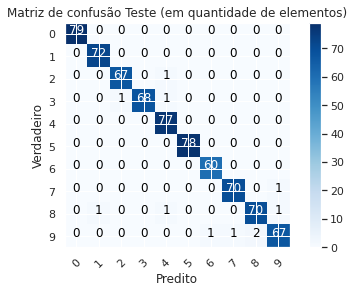

In [0]:
clf = SVC(kernel='rbf', C=2.683, gamma = 0.01, decision_function_shape='ovr')
clf.fit(x_train, y_train)

# Calcula matriz de confusão para teste
cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
np.set_printoptions(precision=2)

title = 'Matriz de confusão Teste (em quantidade de elementos)'

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), title=title)

print('Classificações corretas =', accuracy_score(y_test,  clf.predict(x_test), normalize=False))
print('Acurácia normalizada =', recall_score(y_test,  clf.predict(x_test), average='macro'))

Parâmetros obtidos pelo RandomSearch

Vemos que o melhor resultado do Kernel RBF obtido com GridSearch é para C = 100 e Gamma = 0.00464, com acurácia normalizada de 0.9824 na validação. No teste ele manteve a qualidade do resultado, com acurácia normalizada de 0.9800. Abaixo plotamos o Confusion Matrix para o teste:

Matriz de confusão Teste (em quantidade de elementos)
[[79  0  0  0  0  0  0  0  0  0]
 [ 0 72  0  0  0  0  0  0  0  0]
 [ 0  0 68  0  0  0  0  0  0  0]
 [ 0  0  2 68  0  0  0  0  0  0]
 [ 0  0  0  0 77  0  0  0  0  0]
 [ 0  0  0  0  0 77  0  0  0  1]
 [ 1  1  0  0  0  0 58  0  0  0]
 [ 0  0  0  0  1  0  0 69  0  1]
 [ 0  2  1  0  1  0  0  0 69  0]
 [ 0  0  0  0  0  0  0  1  2 68]]
Classificações corretas = 705
Acurácia normalizada = 0.9800057669515514


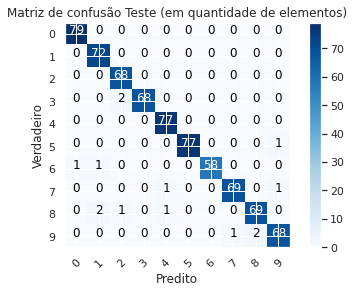

In [108]:
clf = SVC(kernel='rbf', C=100, gamma = 0.00464, decision_function_shape='ovr')
clf.fit(x_train, y_train)

# Calcula matriz de confusão para teste
cnf_matrix = confusion_matrix(y_test, clf.predict(x_test))
np.set_printoptions(precision=2)

title = 'Matriz de confusão Teste (em quantidade de elementos)'

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(set(y_train)), title=title)

print('Classificações corretas =', accuracy_score(y_test,  clf.predict(x_test), normalize=False))
print('Acurácia normalizada =', recall_score(y_test,  clf.predict(x_test), average='macro'))

Através da acurácia normalizada no teste, podemos concluir que o GridSearch apresentou os melhores resultados.